# Neighborhood Modeling

TBD

# Summary

TBD

In [1]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
from scipy.fft import fft, fftfreq, fftshift
import scipy

# Set style
plt.style.use('seaborn')

In [2]:
# Import util file

from util import dickey_fuller, process_neighborhood, report_metrics, plot_results

In [3]:
# Modeling

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsa

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima.arima.stationarity import ADFTest

from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [4]:
df_citibike = pd.read_csv('./clean_data/final_clean_ridership.csv', low_memory=False)

In [6]:
# Import clean dataset

df_citibike = pd.read_csv('./clean_data/final_clean_ridership.csv', low_memory=False)

# Convert starttime to date and set as index

df_citibike['starttime'] = pd.to_datetime(df_citibike['starttime'])

df_citibike.set_index('starttime', inplace=True)

# Create the daily file

daily_ridership = df_citibike[['ride_count']].resample('1D').sum()

# Filter for only data prior to 5/1/2021 (logic for this is in the EDA notebook)
# daily_ridership = daily_ridership[daily_ridership.index < '2021-06-01']

# Backfill dates with 0 rides (logic for this change in EDA notebook)
daily_ridership['ride_count'] = daily_ridership['ride_count'].replace(to_replace=0, method='bfill')

In [7]:
# Read in clean neighborhood list and convert to list

temp_df = pd.read_csv('./clean_data/neighborhood_list.csv', low_memory=False)

neighborhood_list = list(temp_df.iloc[:,1])

In [8]:
# Process each of the DFs in the neighborhood list

df_dict = {}

for neighborhood in neighborhood_list:
    df = process_neighborhood(df_citibike, neighborhood)
    df_dict[neighborhood] = df

In [9]:
# Resample for weekly based on the results of the overall modeling

for neighborhood, df in df_dict.items():
    df_dict[neighborhood] = df[['ride_count']].resample('W-MON').sum()

In [10]:
# Add future column to define train and test periods

test_start = '2020-03-01'

for neighborhood, df in df_dict.items():
    
    df['future'] = (df.index >= '2020-03-01').astype('int')
    
    df_dict[neighborhood] = df

In [40]:
# Create a dataframe to store neighborhood by neighborhood results

df_results = pd.DataFrame(index=neighborhood_list, columns=['model', 'order', 'seasonal_order',
                                                            'explained_variance', 'MAE', 'MSE', 'R2',
                                                            '2021_actual', '2021_predicted', 'delta', 
                                                            'requires_log'])

In [51]:
# Create another dataframe to store the predictions from each model

df_preds = pd.DataFrame(index=df_dict['Clinton'][df_dict['Clinton'].index >= test_start].index, 
                        columns=neighborhood_list)

In [45]:
# Test for whether I need to log transform ridership column. This test will be based on whether there has been
# an upward trend in the data. Threshold will be set at 50% growth requires logging.

for neighborhood, df in df_dict.items():
    
    # Define growth threshold
    threshold = 0.5
    
    # Decompose time series
    decomposed_ts = decompose(df_clinton['ride_count'].values, 'multiplicative', m=52)
    
    # Look at trend, specifically, and remove nulls
    trend = [trend for trend in decomposed_ts.trend if trend > 0]
    
    # Calculate growth rate (take last and first points)
    growth = (trend[-1] - trend[0]) / trend[0]
    
    # Append True or False to the df_results
    if growth >= threshold:
        df_results.loc[neighborhood, 'requires_log'] = True
        df['ride_count_log'] = df['ride_count'].apply(lambda x: np.log(x))
        df_dict[neighborhood] = df
    else:
        df_results.loc[neighborhood, 'requires_log'] = False

## First Arima Model

- Model will use tuned inputs from the overall model

In [63]:
def run_model(results, neighborhood, ts, order, seasonal_order, logged):
    
    '''
    Docstring here. This will be a long one.
    '''
    
    train = ts[ts['future'] == 0]
    test = ts[ts['future'] == 1]

    
    if logged:
        sari_model = SARIMAX(train['ride_count_log'], order=order, seasonal_order=seasonal_order).fit()
    else:
        sari_model = SARIMAX(train['ride_count'], order=order, seasonal_order=seasonal_order).fit()
    
    # Add preds to predictions DataFrame
    preds = sari_model.forecast(steps = len(test))
    if logged:
        df_preds.loc[:,neighborhood] = np.exp(preds)
    else:
        df_preds.loc[:,neighborhood] = preds
    
    # Retrieve metrics
    if logged:
        model_results = report_metrics(test['ride_count'], np.exp(preds), False)
    else:
        model_results = report_metrics(test['ride_count'], preds, False)
    
    # Calculate actual vs. predicted rides for 2021
    actual_rides_2021 = ts[ts.index > '12/31/2020']['ride_count'].sum()
    pred_rides_2021 = df_preds[df_preds.index > '12/31/2020'][neighborhood].sum()
    
    ride_delta = np.abs(pred_rides_2021 - actual_rides_2021)
    
    # Add results to results dataframe
    results.loc[neighborhood, 'model'] = sari_model
    results.loc[neighborhood, 'order'] = order
    results.loc[neighborhood, 'seasonal_order'] = seasonal_order
    results.loc[neighborhood, 'explained_variance'] = model_results[0]
    results.loc[neighborhood, 'MAE'] = model_results[1]
    results.loc[neighborhood, 'MSE'] = model_results[2]
    results.loc[neighborhood, 'R2'] = model_results[3]
    results.loc[neighborhood, '2021_actual'] = actual_rides_2021
    results.loc[neighborhood, '2021_predicted'] = pred_rides_2021
    results.loc[neighborhood, 'delta'] = ride_delta

In [ ]:
# Test to see if the function works correctly

run_model(df_results, 'Clinton', df_dict['Clinton'], (3, 1, 1), (1, 1, 0, 52), 
          df_results.loc['Clinton', 'requires_log'])

In [67]:
# Run the baseline model for every neighborhood

for neighborhood, df in df_dict.items():
    run_model(df_results, neighborhood, df, (3, 1, 1), (1, 1, 0, 52), df_results.loc[neighborhood, 'requires_log'])

In [68]:
df_results

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log
Clinton,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.699456,3035.75,3889.03,0.529161,704821,759447,54626.1,True
SoHo-TriBeCa-Civic Center-Little Italy,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.665082,7388.29,9236.22,0.348613,1263088,1.41758e+06,154497,True
Chinatown,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.719593,4974.8,5736.57,-0.0751791,674235,870513,196278,True
Fort Greene,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.614105,1491.65,1867.65,0.454462,308811,322348,13537.4,True
Hudson Yards-Chelsea-Flatiron-Union Square,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.666292,19486.2,21922.7,-0.474013,2184965,2.92798e+06,743010,True
Bedford,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.697074,789.686,959.097,0.690382,206680,222106,15426.2,True
West Village,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.64564,9172.35,11081.7,0.45458,1568203,1.68439e+06,116183,True
Midtown-Midtown South,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.535375,13244.9,15419.9,-0.531928,1557490,1.96683e+06,409338,True
Brooklyn Heights-Cobble Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.503421,1225.38,1495.06,0.494937,246421,216758,29662.9,True
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.70057,3189.11,3900.82,0.243375,536478,631590,95112.3,True


### Scratchwork below (attempting to systematically identify seasonality)

In [34]:
df_clinton = df_dict['Clinton']

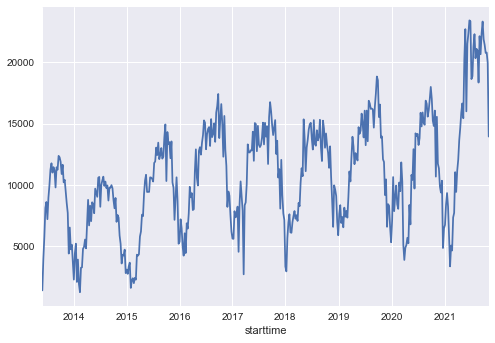

In [126]:
df_clinton['ride_count'].plot();

In [38]:
df_clinton.head(1)

,ride_count
starttime,
2013-06-03,1403


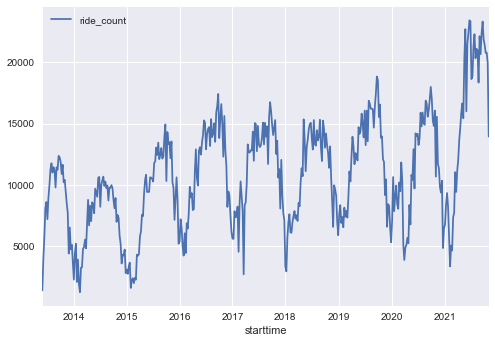

In [36]:
df_clinton.plot();

In [46]:
df_clinton.drop('fft', axis=1, inplace=True)

In [49]:
df_clinton['future'] = (df_clinton.index >= '2020-03-31').astype('int')

df_clinton.insert(0, 't', range(len(df_clinton)))

In [51]:
df_clinton.tail()

,t,ride_count,future
starttime,,,
2021-10-04,435,21407,1
2021-10-11,436,20759,1
2021-10-18,437,20780,1
2021-10-25,438,19949,1
2021-11-01,439,13942,1


In [52]:
X_train = df_clinton.loc[df_clinton.future == 0, 't'].values.reshape(-1, 1)
X_test = df_clinton.loc[df_clinton.future == 1, 't'].values.reshape(-1, 1)

# The train set is the actual value in the series
y_train = df_clinton.loc[df_clinton.future == 0, 'ride_count'].values
y_test = df_clinton.loc[df_clinton.future == 1, 'ride_count'].values

In [73]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = list(lr.predict(X_test))
y_trend_lr = list(lr.predict(X_train))

In [77]:
# Add predictions to the dataframe

df_clinton['preds'] = y_trend_lr + y_preds_lr
df_clinton['resid'] = df_clinton['ride_count'] - df_clinton['preds']
df_clinton.head()

,t,ride_count,future,preds,resid
starttime,,,,,
2013-06-03,0,1403,0,7495.296684,-6092.296684
2013-06-10,1,3953,0,7509.851496,-3556.851496
2013-06-17,2,5775,0,7524.406308,-1749.406308
2013-06-24,3,8119,0,7538.961120,580.038880
2013-07-01,4,8607,0,7553.515932,1053.484068


In [79]:
residuals

starttime
2013-06-03   -6092.296684
2013-06-10   -3556.851496
2013-06-17   -1749.406308
2013-06-24     580.038880
2013-07-01    1053.484068
                 ...     
2021-10-04    7580.360093
2021-10-11    6917.805281
2021-10-18    6924.250469
2021-10-25    6078.695657
2021-11-01      57.140845
Freq: W-MON, Name: resid, Length: 440, dtype: float64

In [85]:
# Create the Fourier transformation

time = df_clinton['t']
residuals = df_clinton['resid']

fft_output = fft(residuals.values)
power = np.abs(fft_output)
freq = fftfreq(len(residuals))

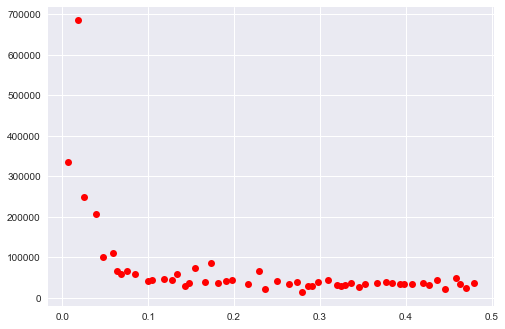

In [89]:
peaks = scipy.signal.find_peaks(power[freq >=0], prominence=10**4)[0]
peak_freq = freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro');

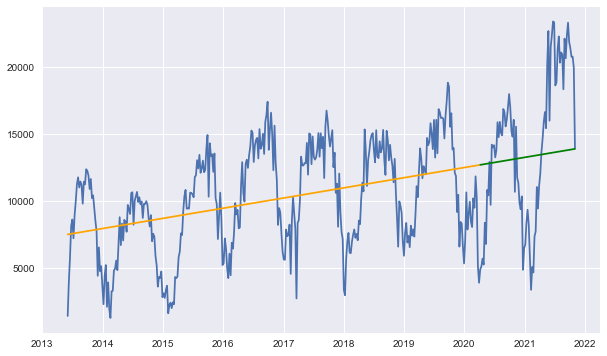

In [54]:
# Plot results

plt.figure(figsize=(10,6))
plt.plot(df_clinton['ride_count'])
plt.plot(df_clinton.loc[df_clinton.future == 0].index, y_trend_lr, color='orange')
plt.plot(df_clinton.loc[df_clinton.future == 1].index, y_preds_lr, color='green')
plt.show()

### Search for a systematic way to find seasonality

In [90]:
df_clinton.head()

,t,ride_count,future,preds,resid
starttime,,,,,
2013-06-03,0,1403,0,7495.296684,-6092.296684
2013-06-10,1,3953,0,7509.851496,-3556.851496
2013-06-17,2,5775,0,7524.406308,-1749.406308
2013-06-24,3,8119,0,7538.961120,580.038880
2013-07-01,4,8607,0,7553.515932,1053.484068


In [104]:
seasonal = pd.DataFrame(decomposed_ts.seasonal, index=df_clinton.index, columns=['Seasonal Ridership'])

seasonal

,Seasonal Ridership
starttime,
2013-06-03,1213.634615
2013-06-10,2207.835165
2013-06-17,2258.835165
2013-06-24,2907.835165
2013-07-01,2980.368132
...,...
2021-10-04,3496.164835
2021-10-11,3491.912088
2021-10-18,2530.681319


In [109]:
# for i, year in enumerate(list(seasonal.index.year.unique())):
#     if i == 2:
#         temp_df1 = seasonal[seasonal.index == year]
#         temp_df2 = seasonal[seasonal.index == year + 1]
        
#     if temp_df1['ride_count']

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

In [99]:
pm.arima.nsdiffs(df_clinton['ride_count'].values, m=52)

0

In [ ]:
pmdarima.arima.nsdiffs()

In [ ]:
best_arima = SARIMAX(train_weekly2, order=(3, 1, 1), seasonal_order=(1, 1, 0, 52)).fit()